In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re  # Keep only if needed for text processing
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For better plots
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.model_selection import GridSearchCV, train_test_split
from itertools import combinations


# **Load Dataset**

In [4]:
# Load dataset with explicit dtype and disable warning
file_path = "/content/merged_hdb_resale_data.csv"
df = pd.read_csv(file_path, dtype={'remaining_lease': str}, low_memory=False)  # Fix DtypeWarning

# Convert 'remaining_lease' to numeric
def extract_years(lease):
    if pd.isna(lease) or lease is None:
        return np.nan
    if isinstance(lease, (int, float)):  # Skip processing if already numeric
        return lease
    if isinstance(lease, str):
        lease = lease.split(" ")[0]  # Extract number of years
        if lease.isdigit():
            return int(lease)
    return np.nan

df['remaining_lease'] = df['remaining_lease'].apply(extract_years)

# Fill missing values using lease_commence_date
current_year = datetime.now().year
df['estimated_remaining_lease'] = 99 - (current_year - df['lease_commence_date'])
df['remaining_lease'] = df['remaining_lease'].fillna(df['estimated_remaining_lease'])

# Drop temporary column
df.drop(columns=['estimated_remaining_lease'], inplace=True)

# Check if missing values are fixed
print(f"Missing remaining_lease: {df['remaining_lease'].isnull().sum()} (should be 0)")
print(df[['remaining_lease', 'lease_commence_date']].head())  # Preview cleaned data


Missing remaining_lease: 0 (should be 0)
   remaining_lease  lease_commence_date
0             51.0                 1977
1             51.0                 1977
2             51.0                 1977
3             51.0                 1977
4             50.0                 1976


# **Preprocessing for transaction**


In [5]:
df['month'] = pd.to_datetime(df['month'])  # Ensure month is datetime type
df = df.sort_values(by='month')  # Ensure chronological order

# Count transactions per month
df_transactions = df.groupby('month').size().reset_index(name='num_resale_transactions')

print(df_transactions)


         month  num_resale_transactions
0   1990-01-01                     1495
1   1990-02-01                      926
2   1990-03-01                     1141
3   1990-04-01                     1045
4   1990-05-01                      774
..         ...                      ...
417 2024-10-01                     2139
418 2024-11-01                     1931
419 2024-12-01                     2119
420 2025-01-01                     2324
421 2025-02-01                      573

[422 rows x 2 columns]


# **Preprocessing for price**

In [6]:
df_price = df.groupby('month')['resale_price'].mean().reset_index()

print(df_price)


         month   resale_price
0   1990-01-01   65385.872910
1   1990-02-01   68115.172786
2   1990-03-01   66883.916740
3   1990-04-01   66010.688995
4   1990-05-01   68052.824289
..         ...            ...
417 2024-10-01  629425.648845
418 2024-11-01  635662.313765
419 2024-12-01  637794.468617
420 2025-01-01  635886.460671
421 2025-02-01  630351.722513

[422 rows x 2 columns]


# **Preprocessing for Location Demand**

In [7]:
# Ensure 'month' is in datetime format
df['month'] = pd.to_datetime(df['month'])

# Aggregate transactions per month-town
df_location = df.groupby(['month', 'town']).size().reset_index(name='num_transactions')

# Automatically detect the full date range
all_months = pd.date_range(start=df['month'].min(), end=df['month'].max(), freq='MS')
all_towns = df['town'].unique()  # Ensure all towns from original dataset are included

# Create full month-town index
full_index = pd.MultiIndex.from_product([all_months, all_towns], names=['month', 'town'])

# Reindex to fill missing months with 0 transactions
df_location = df_location.set_index(['month', 'town']).reindex(full_index, fill_value=0).reset_index()

print(df_location.head(), df_location.tail())  # Check the first and last rows
print("Final dataset shape:", df_location.shape)  # Should match expected (36*12*towns)


       month             town  num_transactions
0 1990-01-01       ANG MO KIO               151
1 1990-01-01  KALLANG/WHAMPOA                68
2 1990-01-01      JURONG WEST               132
3 1990-01-01       QUEENSTOWN               123
4 1990-01-01    MARINE PARADE                27            month           town  num_transactions
11389 2025-02-01   LIM CHU KANG                 0
11390 2025-02-01      SEMBAWANG                29
11391 2025-02-01  BUKIT PANJANG                23
11392 2025-02-01      PASIR RIS                 7
11393 2025-02-01        PUNGGOL                35
Final dataset shape: (11394, 3)


# **Extract time features**


In [8]:
# Convert 'month' to datetime type
df_location['month'] = pd.to_datetime(df_location['month'])

# Extract time features
df_transactions['year'] = df_transactions['month'].dt.year
df_transactions['month_num'] = df_transactions['month'].dt.month

df_price['year'] = df_price['month'].dt.year
df_price['month_num'] = df_price['month'].dt.month

df_location['year'] = df_location['month'].dt.year
df_location['month_num'] = df_location['month'].dt.month

# Drop 'month' column for XGBoost training
df_location.drop(columns=['month'], inplace=True)


# **Resale Transactions Forecasting Model**

In [9]:
# Generate lag features
lags = [1, 3, 6, 12]  # Short-term and long-term trends
for lag in lags:
    df_transactions[f'lag_{lag}'] = df_transactions['num_resale_transactions'].shift(lag)

# Drop rows with NaN after shifting
df_transactions.dropna(inplace=True)

# Define all possible lag feature sets
feature_combinations = []
for i in range(1, len(lags) + 1):
    feature_combinations.extend(combinations([f'lag_{lag}' for lag in lags], i))

# Prepare GridSearch hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

best_rmse = float("inf")
best_features = None
best_params = None
best_resale_model = None

# Loop through different lag feature sets
for feature_set in feature_combinations:
    print(f"Testing with features: {feature_set}")

    # Define features & target
    X = df_transactions[list(feature_set) + ['year', 'month_num']]
    y = df_transactions['num_resale_transactions']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # GridSearchCV to find best hyperparameters
    model = XGBRegressor()
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3)
    grid_search.fit(X_train, y_train)

    # Get best parameters from GridSearch
    best_params_current = grid_search.best_params_
    print("Best Parameters:", best_params_current)

    # Train model with best parameters
    model = XGBRegressor(**best_params_current)
    model.fit(X_train, y_train)

    # Predictions & Evaluation
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    print(f"RMSE for {feature_set}: {rmse}")

    # Track the best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_features = feature_set
        best_params = best_params_current
        best_resale_model = model

# Print final best model details
print("\n✅ Best Model Found:")
print(f"Best Features: {best_features}")
print(f"Best Parameters: {best_params}")
print(f"Lowest RMSE: {best_rmse}")


Testing with features: ('lag_1',)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
RMSE for ('lag_1',): 439.76831613362054
Testing with features: ('lag_3',)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
RMSE for ('lag_3',): 453.6554481376808
Testing with features: ('lag_6',)
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
RMSE for ('lag_6',): 458.26510477015375
Testing with features: ('lag_12',)
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
RMSE for ('lag_12',): 497.83112410234054
Testing with features: ('lag_1', 'lag_3')
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
RMSE for ('lag_1', 'lag_3'): 413.6956724151221
Testing with features: ('lag_1', 'lag_6')
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
RMSE for ('lag_1', 'lag_6'): 422.0919997465008
Testing with features: ('lag_1', 'lag_12')
Best Parameter

# **Price Trends Forecasting**

In [10]:
# Generate lag features
lags = [1, 3, 6, 12]
for lag in lags:
    df_price[f'lag_{lag}'] = df_price['resale_price'].shift(lag)

# Drop rows with NaN after shifting
df_price.dropna(inplace=True)

# Define all possible lag feature sets
feature_combinations = []
for i in range(1, len(lags) + 1):
    feature_combinations.extend(combinations([f'lag_{lag}' for lag in lags], i))

# Prepare GridSearch hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

best_rmse = float("inf")
best_features = None
best_params = None
best_price_model = None

# Loop through different lag feature sets
for feature_set in feature_combinations:
    print(f"Testing with features: {feature_set}")

    # Define features & target
    X = df_price[list(feature_set) + ['year', 'month_num']]
    y = df_price['resale_price']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # GridSearchCV to find best hyperparameters
    model = XGBRegressor()
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3)
    grid_search.fit(X_train, y_train)

    # Get best parameters from GridSearch
    best_params_current = grid_search.best_params_
    print("Best Parameters:", best_params_current)

    # Train model with best parameters
    model = XGBRegressor(**best_params_current)
    model.fit(X_train, y_train)

    # Predictions & Evaluation
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    print(f"RMSE for {feature_set}: {rmse}")

    # Track the best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_features = feature_set
        best_params = best_params_current
        best_price_model = model

# Print final best model details
print("\n✅ Best Model Found:")
print(f"Best Features: {best_features}")
print(f"Best Parameters: {best_params}")
print(f"Lowest RMSE: {best_rmse}")


Testing with features: ('lag_1',)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
RMSE for ('lag_1',): 81822.21283992125
Testing with features: ('lag_3',)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE for ('lag_3',): 81959.76416792926
Testing with features: ('lag_6',)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
RMSE for ('lag_6',): 90795.78592563933
Testing with features: ('lag_12',)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
RMSE for ('lag_12',): 97717.04367712083
Testing with features: ('lag_1', 'lag_3')
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
RMSE for ('lag_1', 'lag_3'): 77749.33148375462
Testing with features: ('lag_1', 'lag_6')
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
RMSE for ('lag_1', 'lag_6'): 78458.43336018563
Testing with features: ('lag_1', 'lag_12')
Best Parameters: {'

# **Location Demand Forecasting**

In [11]:
# One-hot encode 'town'
df_location = pd.get_dummies(df_location, columns=['town'])

# Generate lag features
lags = [1, 3, 6, 12]  # Different time periods for demand trends
for lag in lags:
    df_location[f'lag_{lag}'] = df_location['num_transactions'].shift(lag)

# Drop rows with NaN after shifting
df_location.dropna(inplace=True)

# Define all possible lag feature sets
feature_combinations = []
for i in range(1, len(lags) + 1):
    feature_combinations.extend(combinations([f'lag_{lag}' for lag in lags], i))

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

best_rmse = float("inf")
best_features = None
best_params = None
best_location_model = None

# Loop through different lag feature sets
for feature_set in feature_combinations:
    print(f"Testing with features: {feature_set}")

    # Define features & target
    X = df_location[list(feature_set) + [col for col in df_location.columns if col.startswith("town_")]]
    y = df_location['num_transactions']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # GridSearchCV to find best hyperparameters
    model = XGBRegressor()
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3)
    grid_search.fit(X_train, y_train)

    # Get best parameters from GridSearch
    best_params_current = grid_search.best_params_
    print("Best Parameters:", best_params_current)

    # Train model with best parameters
    model = XGBRegressor(**best_params_current)
    model.fit(X_train, y_train)

    # Predictions & Evaluation
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    print(f"RMSE for {feature_set}: {rmse}")

    # Track the best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_features = feature_set
        best_params = best_params_current
        best_location_model = model

# Print final best model details
print("\n✅ Best Model Found:")
print(f"Best Features: {best_features}")
print(f"Best Parameters: {best_params}")
print(f"Lowest RMSE: {best_rmse}")


Testing with features: ('lag_1',)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE for ('lag_1',): 44.22131314346977
Testing with features: ('lag_3',)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE for ('lag_3',): 42.19467820875786
Testing with features: ('lag_6',)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
RMSE for ('lag_6',): 44.373642419814516
Testing with features: ('lag_12',)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE for ('lag_12',): 45.45345533138818
Testing with features: ('lag_1', 'lag_3')
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
RMSE for ('lag_1', 'lag_3'): 41.96820317960968
Testing with features: ('lag_1', 'lag_6')
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE for ('lag_1', 'lag_6'): 41.15069426719159
Testing with features: ('lag_1', 'lag_12')
Best Parameters: {'le

# **Save Best Models**

In [12]:
import joblib

# Save the best resale transaction forecasting model
joblib.dump(best_resale_model, "best_resale_transaction_model.pkl")

# Save the best price forecasting model
joblib.dump(best_price_model, "best_price_model.pkl")

# Save the best location demand forecasting model
joblib.dump(best_location_model, "best_location_demand_model.pkl")

print("✅ Models saved successfully!")


✅ Models saved successfully!


# **Creating future data for prediction**

In [13]:
# Load trained models
resale_model = joblib.load("best_resale_transaction_model.pkl")
price_model = joblib.load("best_price_model.pkl")
location_model = joblib.load("best_location_demand_model.pkl")

# Define future months (from March 2025 to December 2026)
future_dates = pd.date_range(start="2025-03-01", end="2026-12-01", freq='MS')  # Monthly start
future_df = pd.DataFrame({"month": future_dates})
future_df["year"] = future_df["month"].dt.year
future_df["month_num"] = future_df["month"].dt.month

# Ensure necessary lag features exist (initially filled with NaN)
lags = [1, 3, 6, 12]  # Use the same lag features as training
for lag in lags:
    future_df[f'lag_{lag}'] = np.nan

# Ensure town columns exist for location demand prediction
towns = [
    "ANG MO KIO", "BEDOK", "BISHAN", "BUKIT BATOK", "BUKIT MERAH",
    "BUKIT PANJANG", "BUKIT TIMAH", "CENTRAL AREA", "CHOA CHU KANG",
    "CLEMENTI", "GEYLANG", "HOUGANG", "JURONG EAST", "JURONG WEST",
    "KALLANG/WHAMPOA", "LIM CHU KANG", "MARINE PARADE", "PASIR RIS",
    "PUNGGOL", "QUEENSTOWN", "SEMBAWANG", "SENGKANG", "SERANGOON",
    "TAMPINES", "TOA PAYOH", "WOODLANDS", "YISHUN"
]

for town in towns:
    future_df[f'town_{town}'] = 0  # Default to 0

print("✅ Future data prepared for prediction!")


✅ Future data prepared for prediction!


# **Resale Transactions Forecasting Visualisation**


       month        lag_1        lag_3       lag_12
0 2025-03-01  2391.270752  2324.000000  1931.000000
1 2025-04-01  2232.599854  2391.270752  2324.000000
2 2025-05-01  2103.994385  2232.599854  2391.270752
3 2025-06-01  1952.784668  2103.994385  2232.599854
4 2025-07-01  1881.520508  1952.784668  2103.994385
5 2025-08-01  1875.513550  1881.520508  1952.784668
6 2025-09-01  1857.625854  1875.513550  1881.520508
7 2025-10-01  1857.010254  1857.625854  1875.513550
8 2025-11-01  1799.708374  1857.010254  1857.625854
9 2025-12-01  1764.960083  1799.708374  1857.010254


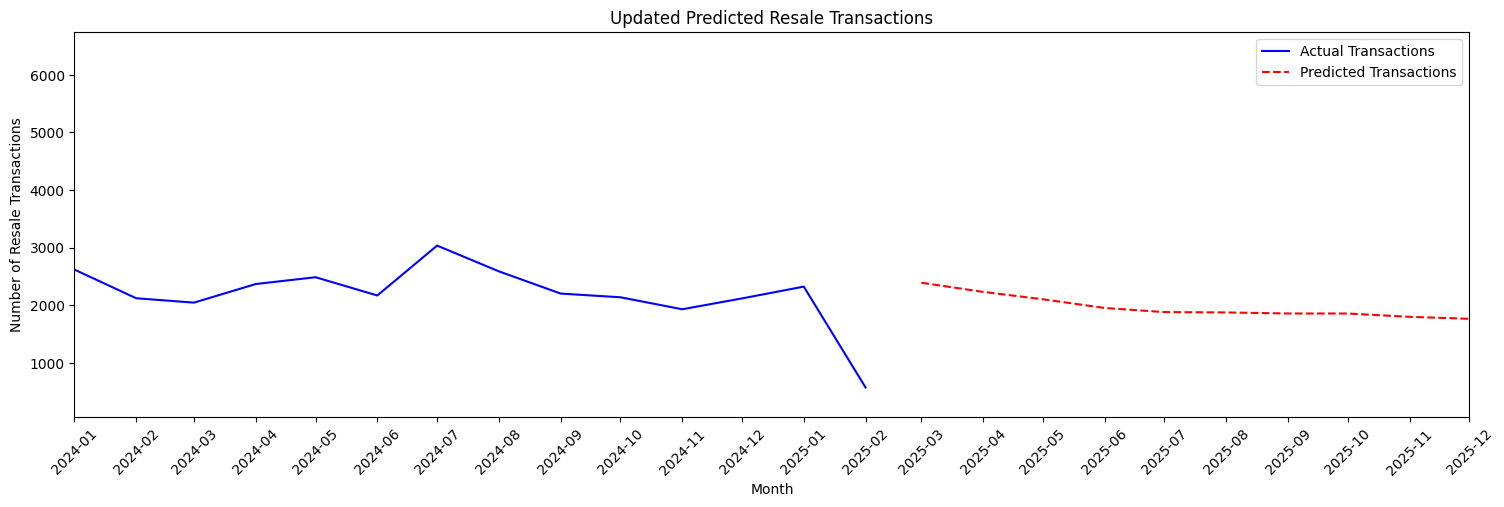

In [14]:
# Get the exact features used in training, in correct order
trained_features = ["lag_1", "lag_3", "lag_12", "year", "month_num"]

# Initialize future_df lag columns with NaN
future_df[['lag_1', 'lag_3', 'lag_12']] = np.nan

# Start with the last known values from actual data
last_known_lags = df_transactions.iloc[-1][['lag_1', 'lag_3', 'lag_12']].to_dict()

# Iteratively predict each month and update lag values
for i in range(len(future_df)):
    # Create input feature row based on last known values
    input_features = pd.DataFrame([{
        'year': future_df.iloc[i]['year'],
        'month_num': future_df.iloc[i]['month_num'],
        'lag_1': last_known_lags['lag_1'],
        'lag_3': last_known_lags['lag_3'],
        'lag_12': last_known_lags['lag_12']
    }])

    # Ensure input features are in the correct order
    input_features = input_features[trained_features]

    # Make a prediction
    predicted_value = resale_model.predict(input_features)[0]
    future_df.at[i, 'predicted_transactions'] = predicted_value  # Store prediction

    # Update lag values for the next iteration
    last_known_lags['lag_12'] = last_known_lags['lag_3']  # Shift lag_3 to lag_12
    last_known_lags['lag_3'] = last_known_lags['lag_1']  # Shift lag_1 to lag_3
    last_known_lags['lag_1'] = predicted_value  # Use predicted value as new lag_1

    # Store updated lag values in `future_df`
    future_df.at[i, 'lag_1'] = last_known_lags['lag_1']
    future_df.at[i, 'lag_3'] = last_known_lags['lag_3']
    future_df.at[i, 'lag_12'] = last_known_lags['lag_12']

# Check if lags are now filled
print(future_df[['month', 'lag_1', 'lag_3', 'lag_12']].head(10))

# Plot the corrected predictions
plt.figure(figsize=(18, 5))

# Plot actual transactions (until Feb 2025)
plt.plot(df_transactions["month"], df_transactions["num_resale_transactions"], label="Actual Transactions", color="blue")

# Plot predicted transactions (from Mar 2025 onwards)
plt.plot(future_df["month"], future_df["predicted_transactions"], label="Predicted Transactions", linestyle="dashed", color="red")

# Adjust X-Axis to Show Only 2024 Onwards
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-01"))

# Set X-Ticks for Every Month in 2024-2026
all_months = pd.date_range(start="2024-01-01", end="2025-12-01", freq="MS")  # MS = Month Start
plt.xticks(all_months, [date.strftime('%Y-%m') for date in all_months], rotation=45)

# Formatting
plt.xlabel("Month")
plt.ylabel("Number of Resale Transactions")
plt.title("Updated Predicted Resale Transactions")
plt.legend()

plt.show()

# **Price Trends Forecasting Visualisation**

       month         lag_1          lag_3       lag_12
0 2025-03-01  476962.15625  635886.460671  1931.000000
1 2025-04-01  477120.71875  476962.156250  2324.000000
2 2025-05-01  473368.03125  477120.718750  2391.270752
3 2025-06-01  468318.71875  473368.031250  2232.599854
4 2025-07-01  462651.84375  468318.718750  2103.994385
5 2025-08-01  458502.03125  462651.843750  1952.784668
6 2025-09-01  456809.37500  458502.031250  1881.520508
7 2025-10-01  456732.31250  456809.375000  1875.513550
8 2025-11-01  455069.18750  456732.312500  1857.625854
9 2025-12-01  454632.00000  455069.187500  1857.010254


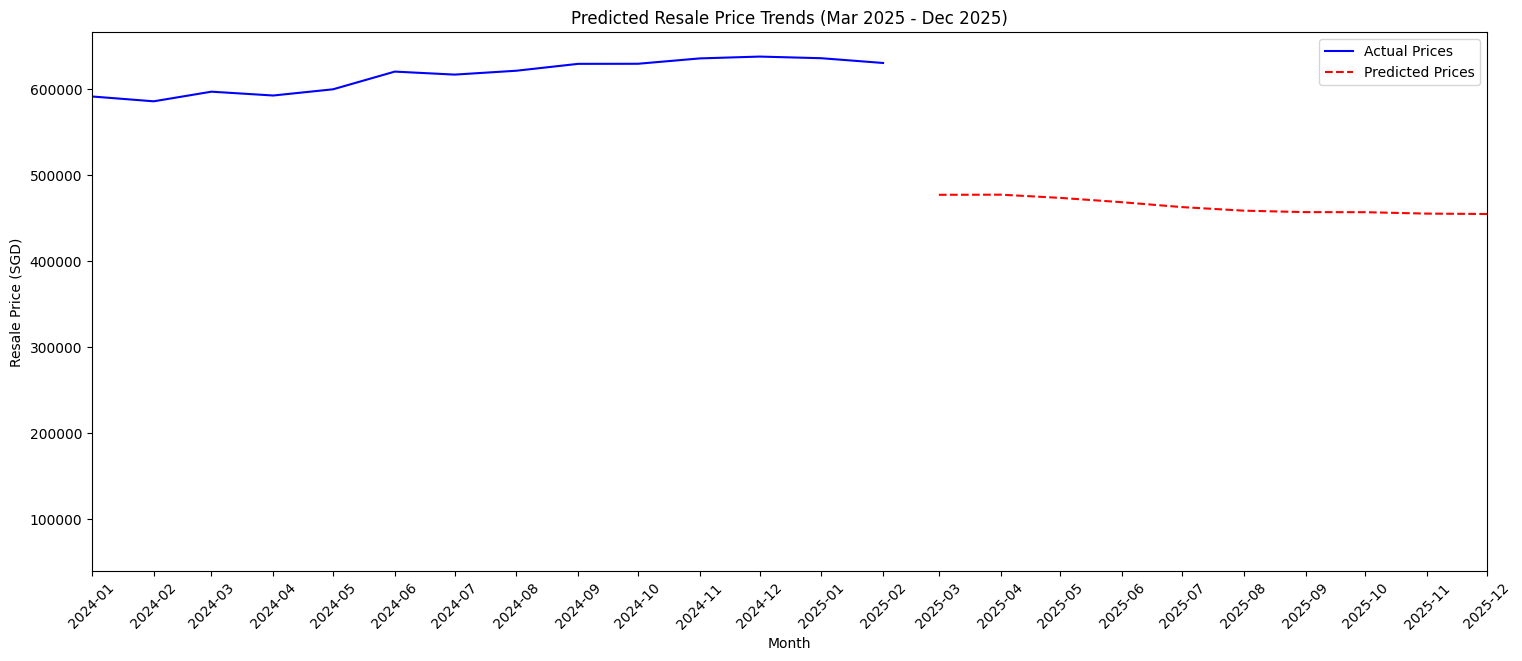

In [15]:
# Ensure features are correctly ordered
trained_features = ["lag_1", "lag_3", "year", "month_num"]

# Initialize future_df with NaN lags
future_df[['lag_1', 'lag_3']] = np.nan

# Start with the last known lag values from actual data
last_known_lags = df_price.iloc[-1][['lag_1', 'lag_3']].to_dict()

# Iteratively predict each month and update lag values
for i in range(len(future_df)):
    # Create input feature row based on last known values
    input_features = pd.DataFrame([{
        'year': future_df.iloc[i]['year'],
        'month_num': future_df.iloc[i]['month_num'],
        'lag_1': last_known_lags['lag_1'],
        'lag_3': last_known_lags['lag_3']
    }])

    # Ensure input feature order matches model
    input_features = input_features[trained_features]

    # Make a prediction
    predicted_value = price_model.predict(input_features)[0]
    future_df.at[i, 'predicted_price'] = predicted_value  # Store prediction

    # Update lag values for next iteration
    last_known_lags['lag_3'] = last_known_lags['lag_1']  # Shift lag_1 to lag_3
    last_known_lags['lag_1'] = predicted_value  # Use predicted value as new lag_1

    # Store updated lag values in `future_df`
    future_df.at[i, 'lag_1'] = last_known_lags['lag_1']
    future_df.at[i, 'lag_3'] = last_known_lags['lag_3']

    # Check if lags are now filled
print(future_df[['month', 'lag_1', 'lag_3', 'lag_12']].head(10))

# Plot the corrected price predictions
plt.figure(figsize=(18, 7))

# Plot actual resale price trends until Feb 2025
plt.plot(df_price["month"], df_price["resale_price"], label="Actual Prices", color="blue")

# Plot predicted price trends from Mar 2025 onwards
plt.plot(future_df["month"], future_df["predicted_price"], label="Predicted Prices", linestyle="dashed", color="red")

# Adjust X-Axis to Start from 2024 and Show Until End of 2025
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-01"))

# Set X-Ticks for Every Month in 2024-2025
all_months = pd.date_range(start="2024-01-01", end="2025-12-01", freq="MS")  # MS = Month Start
plt.xticks(all_months, [date.strftime('%Y-%m') for date in all_months], rotation=45)

# Formatting
plt.xlabel("Month")
plt.ylabel("Resale Price (SGD)")
plt.title("Predicted Resale Price Trends")
plt.legend()

plt.show()

# **Location Demand Forecasting**

       month      lag_1      lag_3     lag_12
0 2025-03-01  25.068388   7.000000   1.000000
1 2025-04-01  34.390476  25.068388  29.000000
2 2025-05-01  41.825024  34.390476   7.000000
3 2025-06-01  42.052902  41.825024  25.068388
4 2025-07-01  42.285984  42.052902  34.390476
5 2025-08-01  42.285984  42.285984  41.825024
6 2025-09-01  43.929077  42.285984  42.052902
7 2025-10-01  44.030048  43.929077  42.285984
8 2025-11-01  44.030048  44.030048  42.285984
9 2025-12-01  44.030048  44.030048  43.929077


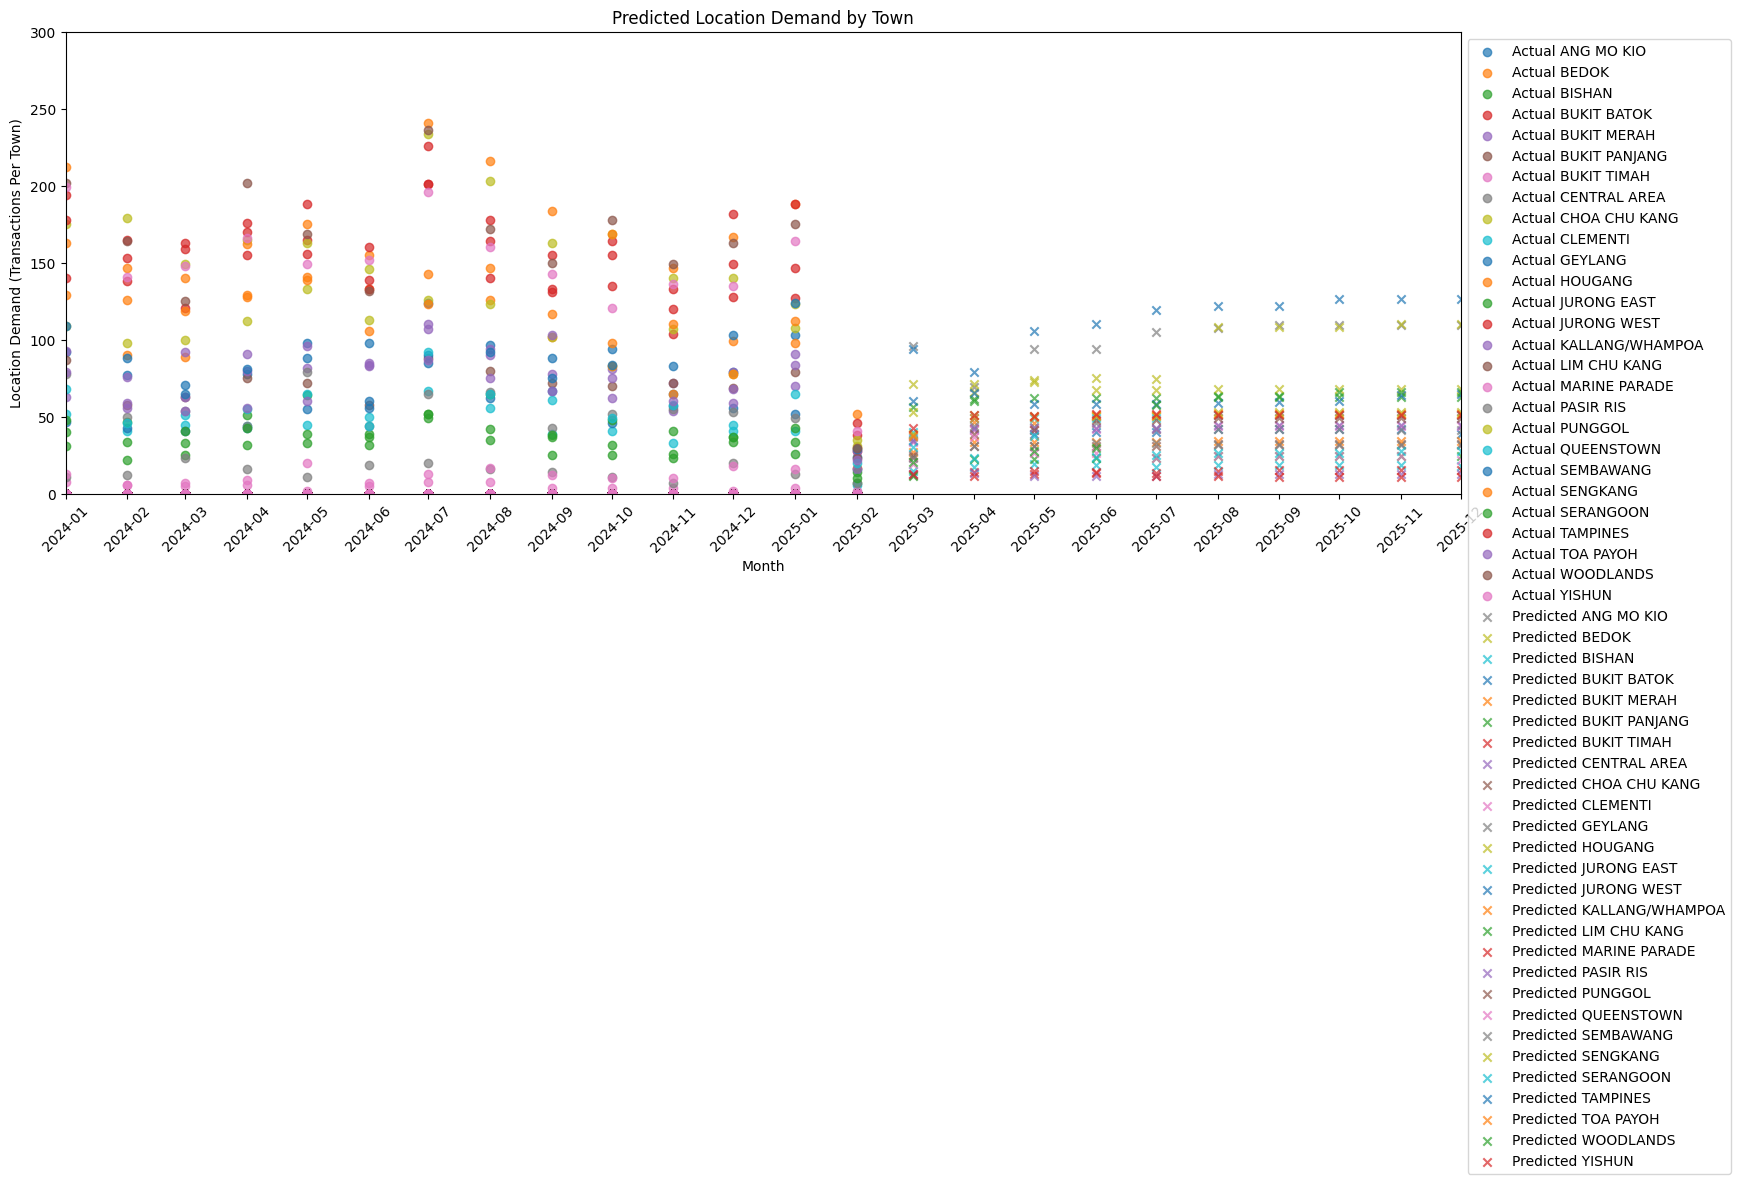

In [17]:
# Define town_columns at the beginning
town_columns = [col for col in df_location.columns if col.startswith("town_")]

# Check if town columns exist in future_df
if not any(col.startswith("town_") for col in future_df.columns):
    print("⚠️ Town columns are missing in future_df. Using last known town data.")

    # Use latest known town values from df_location
    recent_town_data = df_location[town_columns].iloc[-1].to_dict()

    # Add one-hot encoded town columns to future_df
    for col in town_columns:
        future_df[col] = recent_town_data.get(col, 0)  # Use last known values

# Ensure all town columns exist (fill missing ones with 0)
for col in town_columns:
    if col not in future_df.columns:
        future_df[col] = 0  # Add missing town columns as 0

# Ensure features match the trained model (EXCLUDE 'year' & 'month_num')
trained_features = ["lag_1", "lag_3", "lag_6", "lag_12"] + town_columns

# Initialize future_df lag columns with NaN
future_df[['lag_1', 'lag_3', 'lag_6', 'lag_12']] = np.nan

# Start with the last known lag values from actual data
last_known_lags = df_location.iloc[-1][['lag_1', 'lag_3', 'lag_6', 'lag_12']].to_dict()

# Iteratively predict each month and update lag values
for i in range(len(future_df)):
    # Create input feature row based on last known values
    input_features = pd.DataFrame([{
        'lag_1': last_known_lags['lag_1'],
        'lag_3': last_known_lags['lag_3'],
        'lag_6': last_known_lags['lag_6'],
        'lag_12': last_known_lags['lag_12']
    }])

    # Add town features
    for col in town_columns:
        input_features[col] = future_df.iloc[i][col]

    # Ensure input features match the trained model
    input_features = input_features[trained_features]  # EXCLUDES 'year' & 'month_num'

    # Make a prediction
    predicted_value = location_model.predict(input_features)[0]
    future_df.at[i, 'predicted_demand'] = predicted_value  # Store prediction

    # Update lag values for next iteration
    last_known_lags['lag_12'] = last_known_lags['lag_6']
    last_known_lags['lag_6'] = last_known_lags['lag_3']
    last_known_lags['lag_3'] = last_known_lags['lag_1']
    last_known_lags['lag_1'] = predicted_value  # Use predicted value as new lag_1

    # Store updated lag values in `future_df`
    future_df.at[i, 'lag_1'] = last_known_lags['lag_1']
    future_df.at[i, 'lag_3'] = last_known_lags['lag_3']
    future_df.at[i, 'lag_6'] = last_known_lags['lag_6']
    future_df.at[i, 'lag_12'] = last_known_lags['lag_12']

# Check if lags are now filled
print(future_df[['month', 'lag_1', 'lag_3', 'lag_12']].head(10))

# Ensure 'month' exists in both dataframes
if "month" not in future_df.columns:
    future_df["month"] = pd.date_range(start="2025-03-01", periods=len(future_df), freq="MS")

if "month" not in df_location.columns:
# Recreate 'month' column using 'year' and 'month_num'
  df_location["month"] = pd.to_datetime(df_location["year"].astype(str) + "-" + df_location["month_num"].astype(str) + "-01")

# Initialize predicted columns for each town
for town in town_columns:
    future_df[town + "_predicted"] = 0  # Start with 0

# Iterate over towns and make individual predictions
for town in town_columns:
    # Create a temporary dataframe for the prediction
    temp_features = future_df.copy()

    # Set only the current town to 1, others to 0
    for other_town in town_columns:
        temp_features[other_town] = 1 if other_town == town else 0

    # Ensure feature order matches the trained model
    temp_features = temp_features[trained_features]

    # Make predictions
    future_df[town + "_predicted"] = location_model.predict(temp_features)

# Plot actual demand per town (Lines)
plt.figure(figsize=(18, 6))
for town in town_columns:
    plt.scatter(df_location["month"], df_location[town] * df_location["num_transactions"],
                label=f"Actual {town.replace('town_', '')}", alpha=0.7, marker='o')

# Scatter plot for predicted data (2025)
for town in town_columns:
    plt.scatter(future_df["month"], future_df[town + "_predicted"], label=f"Predicted {town.replace('town_', '')}", alpha=0.7, marker='x')

# Adjust X-Axis to Show from 2024 to 2025
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-01"))

# Set X-Ticks for Every Month
all_months = pd.date_range(start="2024-01-01", end="2025-12-01", freq="MS")
plt.xticks(all_months, [date.strftime('%Y-%m') for date in all_months], rotation=45)

# Formatting
plt.xlabel("Month")
plt.ylabel("Location Demand (Transactions Per Town)")
plt.title("Predicted Location Demand by Town")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside
plt.ylim(0, 300)
plt.show()